# Análise da Rede dos Usuários que Tweetaram sobre o BBB22

# Introdução

 Para a realização do presente estudo, foram analisados alguns dados provenientes da API do Twitter. Tal API pode ser acessada através da página do Twitter Developer. Após passar por alguns processos de segurança submetidos pelo próprio Twitter o acesso à API é liberado para que você possa ter acesso alguns a dados (Com algumas limitações de quantidade) disponibilizados pela rede social.<br><br>No que diz respeito a esse trabalho, os dados coletados foram utilizados para a criação de uma rede. Para isso, utilizamos como tema para a realização da pesquisa a hashtag BBB22 (Referente ao reality show Big Brother Brasil 2022).<br><br>Com base nos resultados dessa pesquisa, um grafo (rede) foi criado para analisar os usuários que tweetam sobre a hashtag BBB22 bem como as menções feitas nessas postagens.<br><br>No contexto da rede criada, cada usuário corresponde a um nó na rede e cada menção que um usuário faz a outro corresponde a uma aresta (link) entre o nó referente ao usuário que mencionou e o nó correspondente ao usuário mencionado. A rede modelada se caracteriza como dirigida.

 Desse modo foi gerado o grafo utilizando uma parte do dataset (Com apenas 500 usuários) fornecido com o objetivo de realizar análises sobre a disposição da rede através de grandezas conhecidas, criando gráficos e exibindo os nós com valores mais importantes.

 No que diz respeito ao ranqueamento dos nós (Node Ranking) as métricas estudadas foram: Degree centrality, Betweenness Centrality e EigenVector centrality.

 Além disso, foram feitas uma análise bivariada (PDF e CDF) , uma análise multivariada e uma análise da decomposição da rede.

### Instalação e importação de bibliotecas

In [1]:
# !pip install Twython

In [2]:
#imports
from twython import Twython, TwythonError
import itertools
from time import sleep
import networkx as nx
from tqdm import *
import pickle
from datetime import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Captura de dados com API do Twetter

Para conseguir acesso a API foi necessário criar uma conta como desenvolvedor no Twetter, para que assim fosse criado um projeto, no nosso caso como estudantes, para conseguir as credenciais necessárias para realizar as buscas por dados na API.

O código abaixo pega as credenciais do arquivo `keys.txt`.

In [3]:
# open the keys file
my_file = open("keys.txt", "r")

# read the raw data
content = my_file.read()

# split all lines by  newline character
API_KEY, API_SECRET_KEY = content.split("\n")

# close the file
my_file.close()

A seguir são utilizadas as credenciais do arquivo gerar um link que será utilizado para autenticação.

In [4]:
twitter = Twython(API_KEY, API_SECRET_KEY)

authentication_tokens = twitter.get_authentication_tokens()
print(authentication_tokens['auth_url'])

https://api.twitter.com/oauth/authenticate?oauth_token=23ryoAAAAAABZMV4AAABfwn2IpI


Através do link gerado é possível se autenticar utilizando a conta de desenvolvedor e o projeto criado, para obter o código de acesso que será colocado no input do código abaixo:

In [5]:
# Replace the verifier with the pin number obtained with your web browser in the previous step
VERIFIER = input("codigo da API:")

twitter = Twython(API_KEY, API_SECRET_KEY,
                  authentication_tokens['oauth_token'],
                  authentication_tokens['oauth_token_secret'])

authorized_tokens = twitter.get_authorized_tokens(VERIFIER)

Após a autenticação é possível verificar os dados da conta de desenvolvedor responsável pelo uso da API.

In [6]:
twitter = Twython(API_KEY, API_SECRET_KEY,
                  authorized_tokens['oauth_token'],
                  authorized_tokens['oauth_token_secret'])

twitter.verify_credentials()

{'id': 1492858863963492354,
 'id_str': '1492858863963492354',
 'name': 'Hugo Santos UF',
 'screen_name': 'hf_santosUF',
 'location': '',
 'description': '',
 'url': None,
 'entities': {'description': {'urls': []}},
 'protected': False,
 'followers_count': 0,
 'friends_count': 6,
 'listed_count': 0,
 'created_at': 'Sun Feb 13 13:51:19 +0000 2022',
 'favourites_count': 0,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': False,
 'verified': False,
 'statuses_count': 0,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': 'F5F8FA',
 'profile_background_image_url': None,
 'profile_background_image_url_https': None,
 'profile_background_tile': False,
 'profile_image_url': 'http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png',
 'profile_image_url_https': 'https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png',
 'profile_link_color': '1DA1F2',
 'profile_s

O uso da API possui limitações de busca, com uma certa quantidade de dados que pode ser obtida, essa limitação é reiniciada após 15 minutos, o que faz com que possamos novamente realizar a captura dos dados.

O código abaixo mostra, por exemplo, qual o limite de tweets que podem ser obtidos e quantos restam no momento. No caso  o limite é de 18000 a cada 15 minutos.

In [7]:
twitter.get_application_rate_limit_status()['resources']["search"]

{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645140539}}

Para realizar a busca dos dados de um determinado dia extrapolando a capacidade limitada por tempo da API, foi utilizada a função `sleep()` que consegue fazer o código "dormir" por um certo tempo, que seria aguardar uma quantidade de segundos sem seguir adiante com a execução do código.

Como estamos limitados a uma quantidade de dados a cada 15 minutos, o código de realização da coleta dos dados foi feito de forma que o máximo de dados é extraído e quando a capacidade chega ao limite é chamada a função `sleep()`, que inicia os 15 minutos de timeout, para logo depois coletar novamente os dados, esgotando novamente o limite quantas vezes forem necessárias.

In [14]:
#  Verificando se o limite está completamente disponibilizado

recurso_restante_cheio = False
while(recurso_restante_cheio == False):
  print(twitter.get_application_rate_limit_status()['resources']["search"])

  if(twitter.get_application_rate_limit_status()['resources']["search"]['/search/tweets']['remaining']==180):
    print("Recursos restaurados, iniciando busca!")
    recurso_restante_cheio = True
  
  else:
    print("Ainda não foi restaurada a capacidade de busca!")
    sleep(910)

# quantidade de buscas irão ser realizadas, cada uma terá um intervalo de 15 minutos de espera, fora o tempo de execução da busca na API
quantidade_buscas = 4

search_tweets = []
for busca in range(1,quantidade_buscas+1):
  # a cada 15 min podemos pegar 18 mil tweets
  NUM_TWEETS_TO_FETCH = 18000

  print(twitter.get_application_rate_limit_status()['resources']["search"])
  # realizando coleta e salvando na lista search_tweets
  cursor = twitter.cursor(twitter.search, q='#BBB22', count=100, result_type='mixed')
  search_tweets_atual = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
  search_tweets += search_tweets_atual
  
  # imprime o limite esgotado e qual a busca que foi finalizada
  print(twitter.get_application_rate_limit_status()['resources']["search"])
  print("busca:",busca,"finalizada. aguardando tempo para poder realizar novas requisições.")
  
  # caso não esteja na ultima busca é chamada a função sleep para aguardar 15 minutos e 10 segundos (10 segundos apenas para precaução)
  if(busca != quantidade_buscas):
    sleep(910)

{'/search/tweets': {'limit': 180, 'remaining': 174, 'reset': 1645140541}}
Ainda não foi restaurada a capacidade de busca!
{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645141686}}
Recursos restaurados, iniciando busca!
{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645141687}}
{'/search/tweets': {'limit': 180, 'remaining': 0, 'reset': 1645141687}}
busca: 1 finalizada. aguardando tempo para poder realizar novas requisições.
{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645142764}}
{'/search/tweets': {'limit': 180, 'remaining': 0, 'reset': 1645142764}}
busca: 2 finalizada. aguardando tempo para poder realizar novas requisições.
{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645143819}}
{'/search/tweets': {'limit': 180, 'remaining': 0, 'reset': 1645143819}}
busca: 3 finalizada. aguardando tempo para poder realizar novas requisições.
{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645144871}}
{'/search/tweets': {'l

Abaixo são separados somente os tweets que tem menções a outros usuários, que são os que nos interessam.

In [ ]:
lista_com_mencoes = [tweet  for tweet in search_tweets if  (len(tweet['entities']['user_mentions'])>0)]

Abaixo podemos observar a quantidade total de tweets coletados no dia e quantos possuem menções.

In [ ]:
print("Total:",len(search_tweets),"\nCom menções:",len(lista_com_mencoes))

Total: 72000 
Com menções: 27632


Abaixo utilizamos a biblioteca datetime para capturar a data do dia de hoje, utilizada para compor o nome do arquivo pickle que armazenará a lista de tweets obtidos no dia de hoje.

A biblioteca pickle é utilizada para armazenar em arquivos mais facilmente uma lista ou qualquer estrutura de dados do python.

In [11]:
data = datetime.now().date().strftime('%d-%m-%Y')
print(data)
pickle.dump(lista_com_mencoes, open(f"./dados/lista_com_mencoes{data}.p", "wb"))
# print(f"./dados/lista_com_mencoes{data}.p")

17-02-2022


Após obter os dados a cada dia e realizar a gravação dos mesmos em arquivos é necessário realizar a união de todos para comporem o grafo posteriormente.
O código abaixo realiza essa união de todas as listas dos dias anteriores em uma só: `lista_geral_tweets`.

In [13]:
lista_geral_tweets = []
# o início dos dados foi no dia 13, por isso os arquivos começam a ser capturados do dia 13 até o dia de hoje.
for dia in range(13,datetime.now().day+1):
    print(f"./dados/lista_com_mencoes{dia}-{data[3:]}.p")
    lista_geral_tweets += pickle.load( open(  f"./dados/lista_com_mencoes{dia}-{data[3:]}.p", "rb") )

./dados/lista_com_mencoes13-02-2022.p
./dados/lista_com_mencoes14-02-2022.p
./dados/lista_com_mencoes15-02-2022.p
./dados/lista_com_mencoes16-02-2022.p
./dados/lista_com_mencoes17-02-2022.p


# EDA - Exploraty Data Analysis

#### Para a realização de uma análise exploratória dos dados iremos buscar entender a organização dos dados que vem da API e como poderemos aproveitá-los para criação da nossa rede.

Abaixo está o primeiro tweet capturado para que seja possível analisar quais os dados que podemos trabalhar e qual o formato em que ele se encontra.

In [ ]:
lista_geral_tweets[0]

{'created_at': 'Sun Feb 13 22:27:46 +0000 2022',
 'id': 1492988899081265155,
 'id_str': '1492988899081265155',
 'text': 'RT @vaidesmaiar: Bárbara perguntando do Arthur. Eslô disse que não vota no Arthur. Barbara quer saber o que conversaram. Eslô disse que foi…',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'vaidesmaiar',
    'name': 'Vai Desmaiar #BBB22',
    'id': 511577335,
    'id_str': '511577335',
    'indices': [3, 15]}],
  'urls': []},
 'metadata': {'iso_language_code': 'pt', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1371886809400143872,
  'id_str': '1371886809400143872',
  'name': 'isabella',
  'screen_name': 'isabellafmcc',
  'location': 'São Luís, Brasil',
  

Podemos observar que cada tweet possui dados sobre o usuário que o realizou e também algumas informações sobre o usuário que foi mencionado nesse tweet.

Infelizmente não possuimos muitos dados sobre os usuários mencionados como temos sobre o dono do tweet, o que nos limita em certo ponto, além de que os dados sobre o dono do tweet não aparentam ter grande relevância para levarmos em consideração além da localização `location`, que seria interessante de trabalhar-mos se tivessemos também essa informação dos mencionados.

 Nesse caso iremos trabalhar apenas com os nomes dos usuários e realizar uma avaliação sobre a relevância de cada conta a partir do número de vezes em que ela é mencionada por outros usuários em seus tweets.

 Para podermos entender-mos o volume de dados com que estamos trabalhando iremos realizar algumas observações a seguir.

In [ ]:
# Quantidade de tweets capturados unindo todos os dias de captura
print("Quantidade geral de tweets:",len(lista_geral_tweets))

# Soma menções dos tweets
quantidade_mentions = 0
lista_usuarios_donos = []
lista_usuarios_mencionados = []
for tweet in lista_geral_tweets:
    lista_usuarios_donos.append(tweet['user']['screen_name'])
    quantidade_mentions += len(tweet['entities']['user_mentions'])
    for mention in tweet['entities']['user_mentions']:
        lista_usuarios_mencionados.append(mention['screen_name'])
print("Quantidade geral de menções de todos os tweets:",quantidade_mentions)



Quantidade geral de tweets: 208386
Quantidade geral de menções de todos os tweets: 212644


Observando os dados de quantidade de tweets e de menções é possível entender que pouquíssimos tweets fazem menção a mais de um usuário, a grande maioria das menções são devidos ao tweet ser um retweet de outro usuário, logo contém apenas uma menção.

#### 10 usuários com maior número de tweets:


10 Usuários com maior número de tweets:
Usuário: suelivitoria  -  352
Usuário: fwntdz  -  328
Usuário: dorismac64  -  272
Usuário: gobrotherr  -  220
Usuário: dri_nai  -  215
Usuário: KHHWHAT  -  192
Usuário: jaqueli99515863  -  188
Usuário: tia_meigh2  -  188
Usuário: guricomenta  -  172
Usuário: juuh6520  -  169


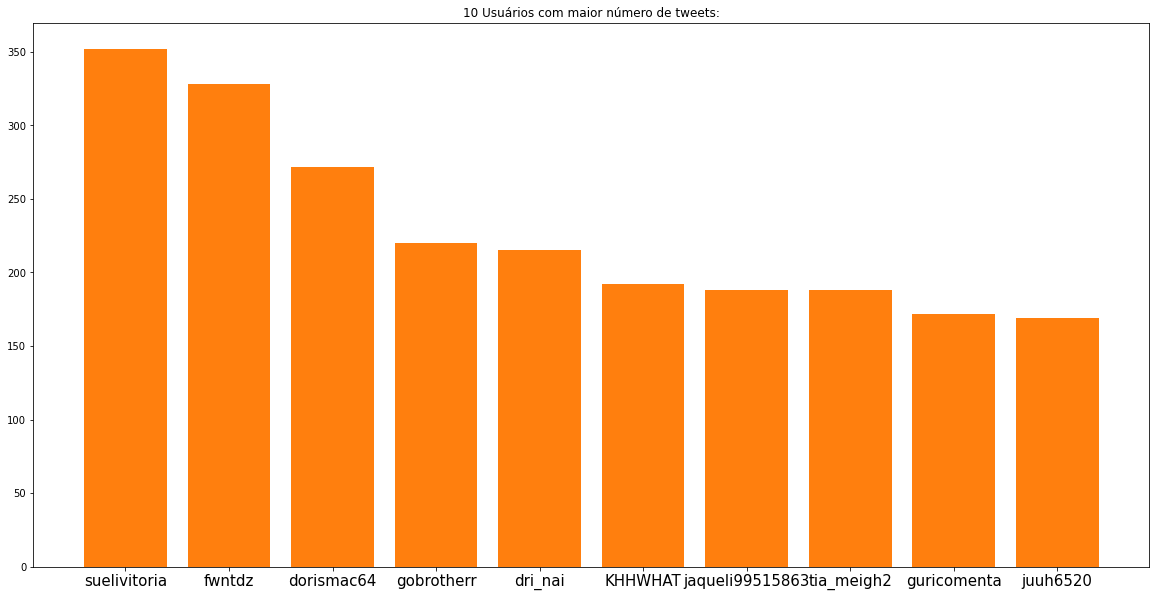

In [ ]:
df_users = pd.DataFrame()
df_users["users"] = lista_usuarios_donos

# Usuários com mais tweets 
print("\n10 Usuários com maior número de tweets:")
contador = 0
usuarios = []
valores = []
for user,tweets in list(df_users.users.value_counts().items()):
    usuarios.append(user)
    valores.append(tweets)
    print("Usuário:",user," - ",tweets)
    contador +=1
    if(contador ==10):
        break



plt.figure(figsize =(20,10))
plt.bar(usuarios,valores)
plt.xticks(usuarios,fontsize=15)
plt.title("10 Usuários com maior número de tweets:")
plt.bar(usuarios, valores)

plt.show()

#### 10 usuários mais mencionados nos tweets:


10 Usuários mais mencionados nos tweets:
Usuário: vaidesmaiar  -  17897
Usuário: chicobarney  -  13488
Usuário: tracklist  -  11027
Usuário: ZAMENZA  -  7294
Usuário: NazareAmarga  -  4226
Usuário: bchartsnet  -  3942
Usuário: Dantinhas  -  3737
Usuário: choquei  -  3707
Usuário: Itspedrito  -  3465
Usuário: CentralReaIity  -  3454


<BarContainer object of 10 artists>

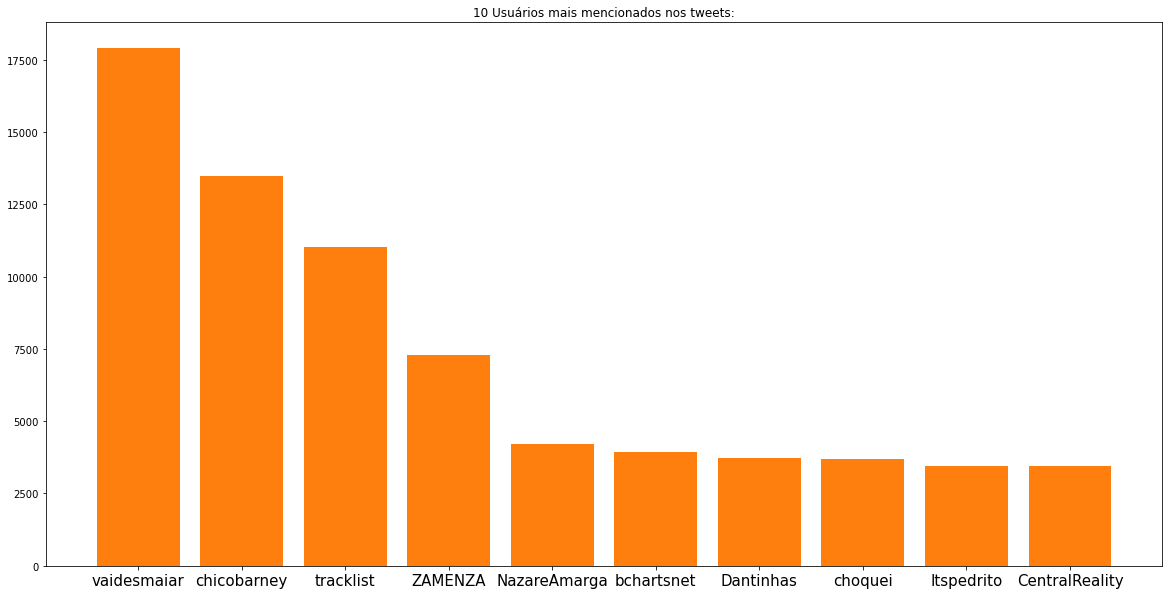

In [ ]:
df_users = pd.DataFrame()
df_users["users"] = lista_usuarios_mencionados

# Usuários mais mencionados
print("\n10 Usuários mais mencionados nos tweets:")
contador = 0
usuarios = []
valores = []

for user,tweets in list(df_users.users.value_counts().items()):
    usuarios.append(user)
    valores.append(tweets)
    print("Usuário:",user," - ",tweets)
    contador +=1
    if(contador ==10):
        break


plt.figure(figsize =(20,10))
plt.bar(usuarios,valores)
plt.xticks(usuarios,fontsize=15)
plt.title("10 Usuários mais mencionados nos tweets:")
plt.bar(usuarios, valores)

# Criando, corrigindo e analizando o Grafo 

O grafo é criado utilizando o Networkx, em que é criado um grafo dirigido e que terá como peso a quantidade de menções que um usuário fez ao outro em seus tweets.

Por exemplo, se @João fez 2 tweets mencionando @Maria então a rede irá possuir a seguinte forma: 

João ----> Maria, em que o peso dessa aresta seria 2, devido aos 2 tweets.

Abaixo está o código responsável pela criação da rede dessa forma.

In [ ]:
# cria o grafo vazio
D = nx.DiGraph()
# utilizado para criação de uma parra de progresso
pbar = tqdm(total=len(lista_geral_tweets)) 

# itera por tweets
for tweet in lista_geral_tweets:
    # dono do tweet
    tweet_sn = tweet['user']['screen_name']
    
    # usuários mencionados
    for user_mention in tweet['entities']['user_mentions']:
        mentioned_sn = user_mention['screen_name']  
        my_edge = (tweet_sn, mentioned_sn)
        # adiciona arestas do dono para os mencionados
        if D.has_edge(*my_edge):
            D.edges[my_edge]['weight'] += 1
        else:
            D.add_edge(*my_edge, weight=1)
    pbar.update(1)
    

 97%|█████████▋| 175971/180754 [00:02<00:00, 69772.88it/s]

Com o objetivo de possibilitar as análises do grafo em tempo hábil foi realizada a filtragem do número de nós, mantendo somente os 500 que possuem maior observando suas arestas.

Para isso foi necessário primeiro observar quem são os graficos com maior grau:

In [ ]:
# Pegando usuários com maior Grau e salvando em lista
lista_pesos = [[peso[1],peso[0]] for peso in list(D.degree(weight='weight'))]
lista_pesos.sort(reverse=True)

# Pegando lista somente com nomes de usuários na ordem de maior grau para o menor
lista_usuarios = [usuario for grau,usuario in lista_pesos]

Abaixo está o código que exibe os 10 nós com maior peso, e qual o seu peso.

In [ ]:
lista_pesos[:10]

[[15192, 'vaidesmaiar'],
 [12877, 'chicobarney'],
 [8035, 'tracklist'],
 [6790, 'ZAMENZA'],
 [3736, 'NazareAmarga'],
 [3590, 'Dantinhas'],
 [3445, 'Itspedrito'],
 [3272, 'bchartsnet'],
 [3192, 'choquei'],
 [2955, 'bbb']]

Abaixo o código em que é possível escolher quantos nós serão mantidos.

In [ ]:
# Quantidade de nós com maior grau que serão mantidos no grafo
quantidade_nodes = 500

# Cria um grafo somente com os nodes desejados 
subgraph = D.subgraph(lista_usuarios[:quantidade_nodes])

# Armazena grafo em arquivo para usos posteriores
nx.write_graphml(subgraph, str(quantidade_nodes)+'_perfis.graphml')


# Node ranking

Foram analisadas também algumas métricas referentes ao Node Ranking, isto é, o ranqueamento dos nós. Através dessas métricas de ranqueamento podemos definir a importância de um nó para a rede.

### Degree Centrality

Antes de falarmos da métrica degree centrality, é interessante o conhecimento sobre o degree (grau) de um nó.

O grau de um nó, nada mais é do que a quantidade de conexões que um nó tem. Por exemplo, se um nó possui 5 conexões então ele possui grau 5.

O código a seguir gera um gráfico que mostra a relação dos nós da rede analisada com seus graus:

100%|██████████| 180754/180754 [00:20<00:00, 69772.88it/s]

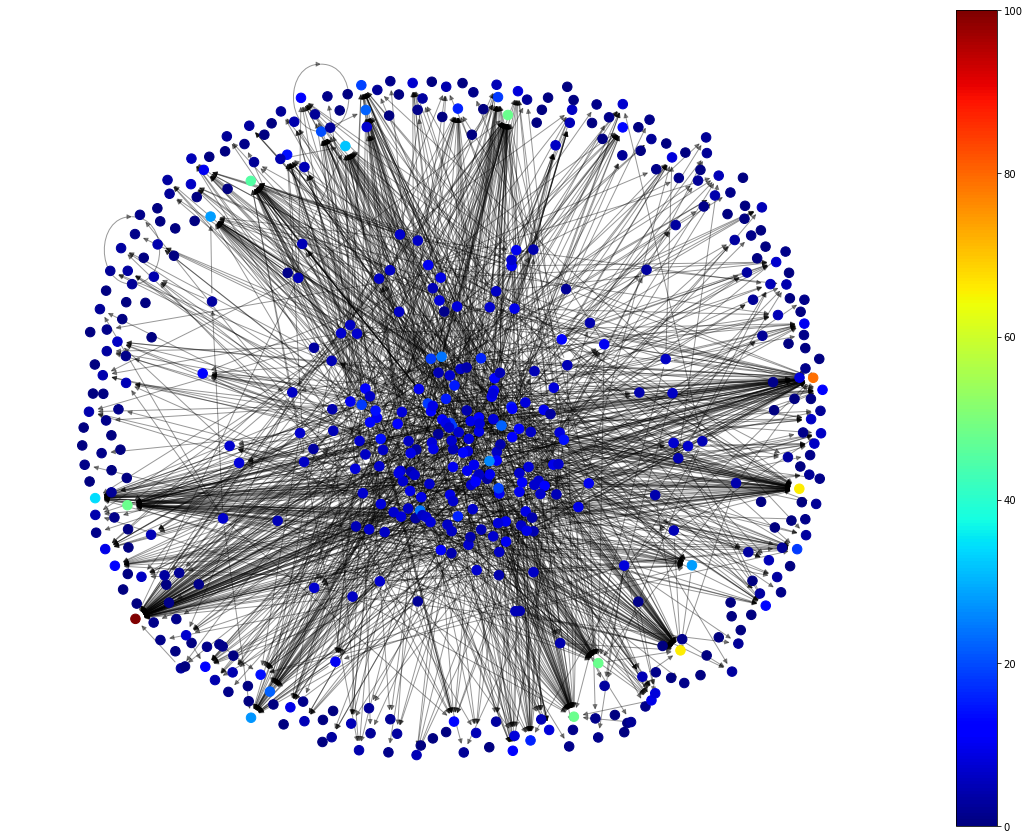

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes based on eccentricity
color = list(dict(nx.degree(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('./figuras/eccentricity.png', transparent=True,dpi=300)
plt.show()



O degree centrality, por sua vez, trata-se do grau de um nó dividido pelo número máximo de vizinhos que um nó pode ter na rede, gerando assim um valor entre 0 e 1.
 
O processo de dividir o grau do nó pelo número máximo possível de vizinhos que ele pode ter é feito para que seja possível comparar redes de tamanhos diferentes utilizando a mesma métrica. Isso porque um nó de grau 5 em uma rede com  10 nós possui uma importância diferente do que se esse mesmo nó estivesse em uma rede com 100 vértices, por exemplo.

Gerando o grafo de degree centrality da nossa rede analisada através do código abaixo obtivemos:

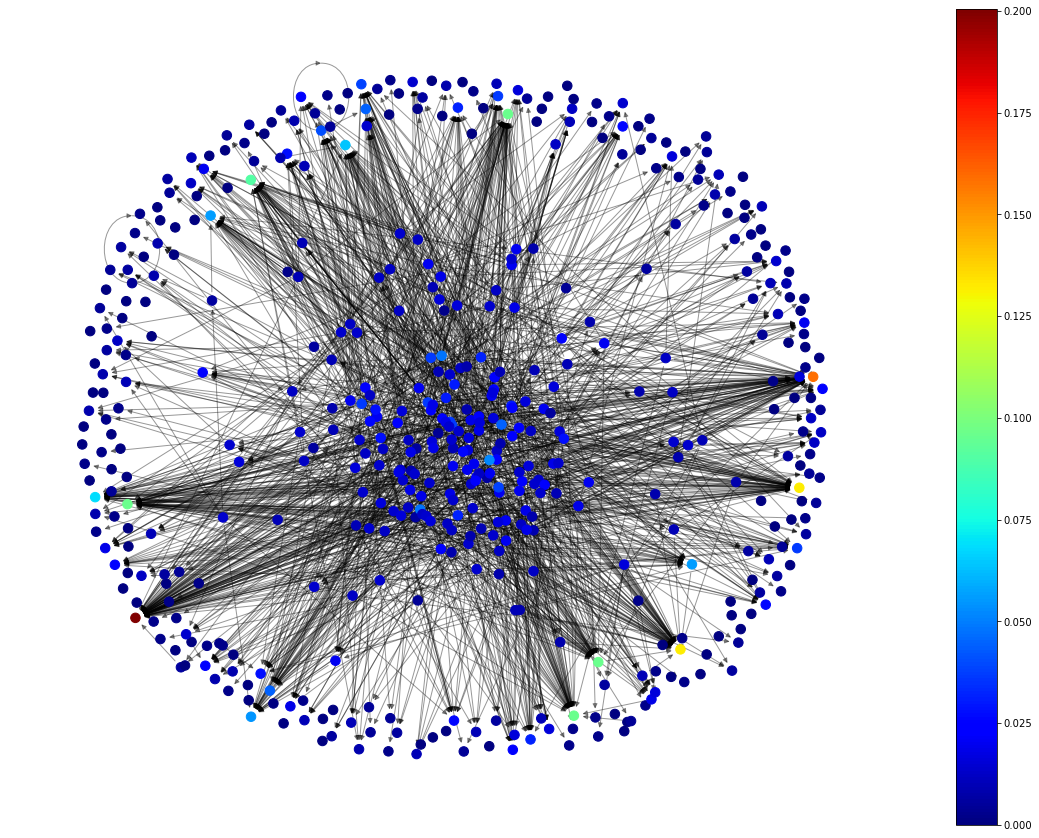

In [ ]:
# the degree centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree_centrality(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('./figuras/degree_centrality.png', transparent=True,dpi=300)
plt.show()

Observando a figura é possível identificar claramente que os nós com valores mais altos de grau possuem realmente mais conexões com outros nós, principalmente os que tem as cores mais próximas ao vermelho.

Perceba que o gráfico é igual ao gráfico de nós comuns, porém com os valores gerados estando entre 0 e 1.

Através do código abaixo foi possível obter a lista dos 10 usuários (nós) com maior grau na rede junto de seus respectivos degree centralities , que são:

In [ ]:
# Pega lista nós e seu respectivo degree_centrality ordenado do maior para o menor
lista_grau_centralidade = [[value,key] for key,value in nx.degree_centrality(subgraph).items()]
lista_grau_centralidade.sort(reverse=True)

# imprime usuários e graus
print("Usuário \t     Grau \n")
for grau,usuario in lista_grau_centralidade[:10]:
  print ("{:<20} {:<15}".format( usuario, grau))

Usuário 	     Grau 

vaidesmaiar          0.2004008016032064
ZAMENZA              0.15831663326653306
bbb                  0.13226452905811623
Dantinhas            0.13226452905811623
tracklist            0.09619238476953906
jadre_oficial        0.09619238476953906
choquei              0.09619238476953906
chicobarney          0.09619238476953906
CentralReaIity       0.09018036072144288
paiva                0.06813627254509018


### Resultado
Observando essa métrica podemos perceber que os nós com maior grau são aqueles com mais relevância dentro da nossa problemática e dentro da rede, pois eles são os que em geral tweets que são constantemente retweetados, pelo maior número de usuários e pelos usuários mais relevantes, e são muito mencionados por outros usuários que estão interessados no programa BBB.

## Betweenness Centrality

Essa métrica define quais são os nós mais importantes em fazer a ligação entre os outros nós, o grau de participação daquele nó nos menores caminhos de todos os nós entre si. Em outras palavras, o quanto um determinado grau faz parte do fluxo de caminhos ou informações.

A figura abaixo exibe a rede sob a ótica da aplicação do Betweenness centrality:

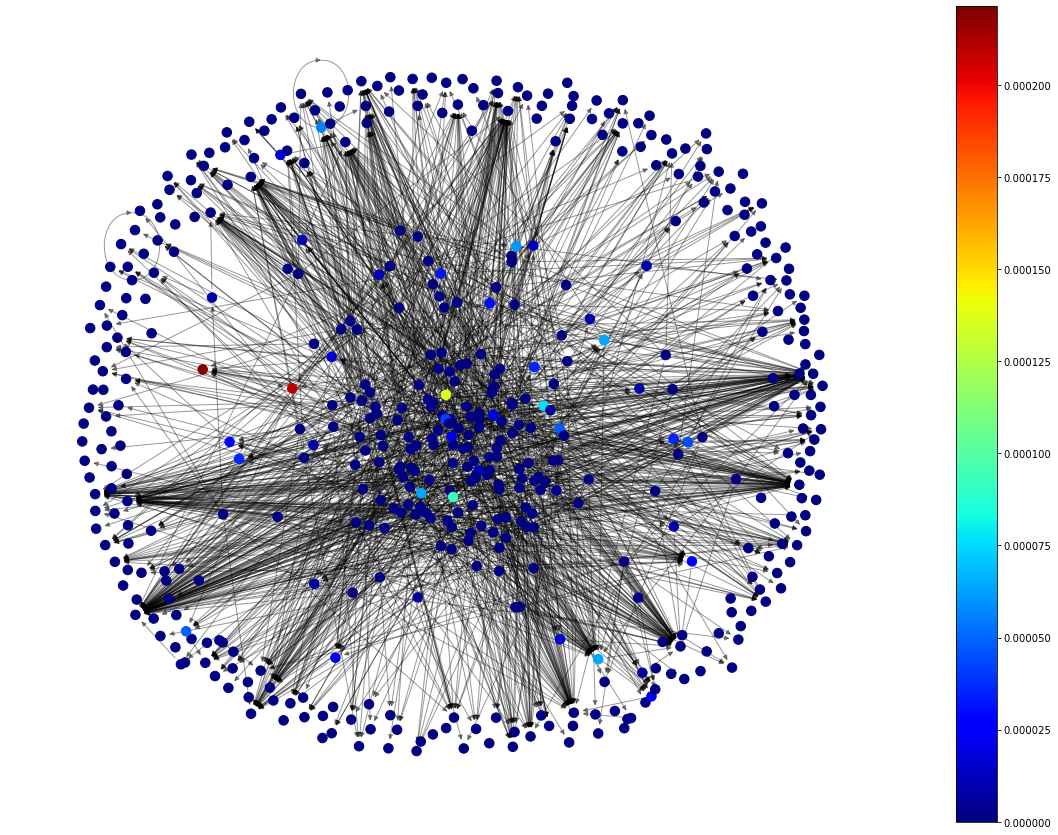

In [ ]:
# the betwenness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.betweenness_centrality(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('./figuras/betweenness_centrality.png', transparent=True,dpi=600)
plt.show()

Observando a figura tendo em mente o conceito da métrica é possível ver claramente que os nós que mais se destacam são aqueles que estão fazendo o intermédio entre os nós com maior grau e o restante dos nós, fazendo a função de ponte entre os nós.

Abaixo estão exibidos os 10 nós com maior destaque na rede para essa métrica:

In [ ]:
# Pega lista nós e seu respectivo betweenness_centrality ordenado do maior para o menor
lista_entre_nodes = [[value,key] for key,value in nx.betweenness_centrality(subgraph).items()]
lista_entre_nodes.sort(reverse=True)

# Imprime usuarios e métrica
print("Usuário \t     Grau \n")
for grau,usuario in lista_entre_nodes[:10]:
  print ("{:<20} {:<15}".format( usuario, grau))

Usuário 	     Grau 

plantasarradora      0.00022132618650956532
dcxdxt               0.00020925384906358903
TvViciada            0.00013681982438773128
frothcream           9.255458708581823e-05
Nnise_Rrose          7.645813715784983e-05
jadre_oficial        6.472114241870622e-05
yliieat              6.438579971187355e-05
aktaion16            6.438579971187355e-05
jessialveshq         6.036168722988145e-05
GregoMalandro        5.633757474788935e-05


### Resultado
Depois de analizar a figura juntamente com os 10 usuários mais destacados nessa métrica é possível perceber que muito provavelmente esses usuários são como se fossem páginas secundárias, que tem seus próprios seguidores e postam seus próprios conteúdos mas também repostam e fazem muitas menções aos usuários mais importantes da rede, os que possuem maior grau, vistos anteriormente na degree centrality.

## EigenVector Centrality

A métrica Eigenvector centrality (Autovetor) mede a importância de um nó de acordo com a importância dos seus vizinhos. A grosso modo, a ideia é a de que se eu sou "amigo" de alguém importante eu sou importante também.

Abaixo a figura exibindo a rede com a aplicação do EigenVector Centrality:

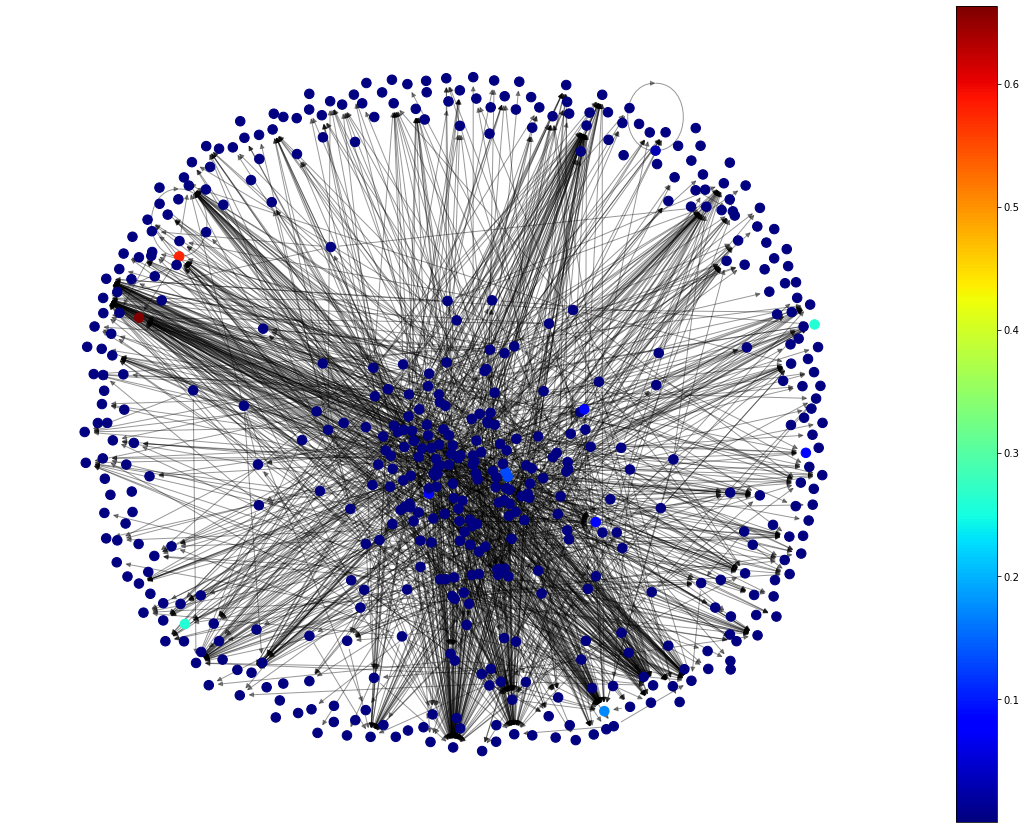

In [ ]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.eigenvector_centrality(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('./figuras/eigenvector_centrality.png', transparent=True,dpi=600)
plt.show()

Abaixo estão exibidos os 10 nós com maior destaque na rede para essa métrica.

In [ ]:
# Pega lista nós e seu respectivo betweenness_centrality ordenado do maior para o menor
lista_autovetor = [[value,key] for key,value in nx.eigenvector_centrality(subgraph).items()]
lista_autovetor.sort(reverse=True)

# Imprime usuários e métrica
print("Usuário \t     Grau \n")
for grau,usuario in lista_autovetor[:10]:
  print ("{:<20} {:<15}".format( usuario, grau))

Usuário 	     Grau 

iampauloandre        0.6627067136854489
GregoMalandro        0.5762673027473645
boninho              0.25932522525177626
PedroScooby          0.25932112729525314
bbb                  0.172908545317226
anafalabobeira2      0.12966016273957442
anafalabobeira       0.12966015715798979
jadepicon            0.08644035207912888
voleimomento         0.08644024774643104
EuFraaan             0.0864401260249501


### Resultado
Devido a natureza da métrica podemos observar que os usuários mais destacados aqui são os mais mensionados pelos usuários mais relevantes, tanto que alguns dos mais destacados são os usuários de participantes do BBB22, como `PedroScooby`, `jadepicon` e `iampauloandre`. Além de termos também perfis de pessoas importantes como o `boninho`, o diretor do BBB.

# Análise Bivariada (PDF e CDF)

A Probability Density Function (PDF) é uma função que possui a capacidade de informar a probabilidade de uma variável assumir um determinado valor.

Aplicamos essa função na rede em relação à métrica degree dos nós para verificarmos a probabilidade de um nó da rede ter um determinado grau.

Abaixo a figura exibindo a rede com a aplicação da PDF em relação ao grau dos nós e o histograma dos graus:

Abaixo a figura exibindo a rede com a aplicação da PDF em relação ao grau dos nós com a linha KDE:

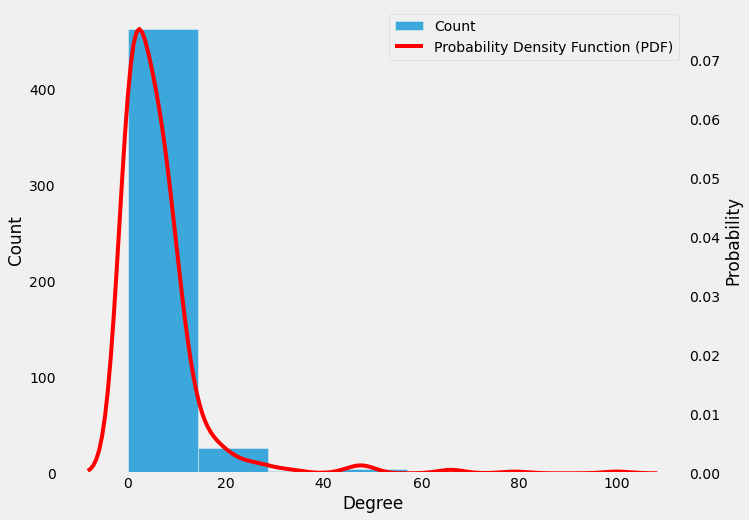

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))
degree_sequence = sorted([d for n, d in subgraph.degree()], reverse=True)  

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('./figuras/probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

### Resultado
A função PDF aplicada ao nosso grafo mostrou que a maioria dos nós possuem grau entre 0 e 20, com alguns poucos acima de 40.

### CDF - Cumulative Density Function

A função Cumulative Density Function tem a capacidade de definir a probabilidade de um dado valor estar em um determinado intervalo acumulado.

Abaixo a figura exibindo a rede com a aplicação da CDF levando em consideração o grau dos nós.

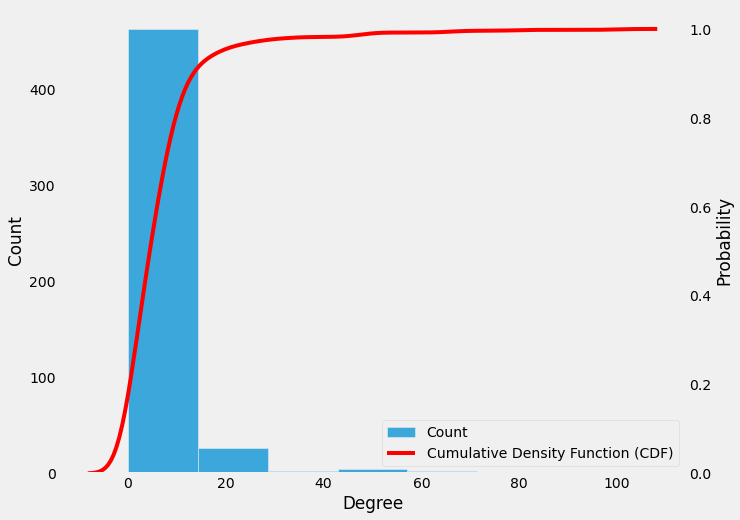

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('./figuras/cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

# Resultado 
Observando essa figura podemos perceber que aproximadamente 90% dos nós está entre 0 e 20 no valor de seus graus.

# Análise de decomposição da rede

A análise de decomposição da rede consiste em decompor a rede em camadas denominadas cores. Cada camada da rede leva em consideração o grau dos nós. Por exemplo, a camada 1-core refere-se ao conjunto de nós das redes cujo grau é no mínimo 1. O 2-core os nós que possuem grau 2 ou maior, 3-core os que possuem grau 3 ou mais etc. O último core de uma rede é denominado núcleo dessa rede.

Além do core, outra ideia utilizada na análise de decomposição é a do shell. O shell faz referência à camada que foi retirada para alcançar um determinado core. Por exemplo, para alcançar a camada 2-core os nós da rede cujo grau é igual a 1 precisou ser retirada, a essa camada retirada dá-se o nome de 1-shell. Assim, para alcançar a camada 3-core precisa-se tirar o 2 shell e assim por diante.

Vale lembrar que essas camadas não precisam necessariamente serem incrementadas de um em um,isto é, pode ser que exista uma rede cujas camadas são: 1-core, 3-core e 4-core. Perceba que nesse exemplo não existe o 2-core, o que é totalmente possível (É como se nessa rede não existissem nós de grau 2).

O trecho de código abaixo nos fornece algumas informações gerais sobre as camadas da rede.

In [ ]:
subgraph_sem_autorreferencia =  nx.Graph(subgraph)
subgraph_sem_autorreferencia.remove_edges_from(nx.selfloop_edges(subgraph_sem_autorreferencia))

core_numbers = nx.core_number(subgraph_sem_autorreferencia).items()
# Imprime o número dos cores da rede
print("Camadas de decomposição:")
print(set([v for k,v in core_numbers]))
print("\nQuantidade de camadas:",len(set([v for k,v in core_numbers])))


# Imprime o número do último core
print("\nÚltima camada de decomposição, core final da rede:",list(set([v for k,v in core_numbers]))[-1])

Camadas de decomposição:
{0, 1, 2, 3, 4, 5, 6, 7}

Quantidade de camadas: 8

Última camada de decomposição, core final da rede: 7


O gráfico abaixo mostra o núcleo da rede junto da camada anterior a esse núcleo que foi retirada (Nesse caso a 6-shell) coloridas de vermelho e azul, respectivamente.

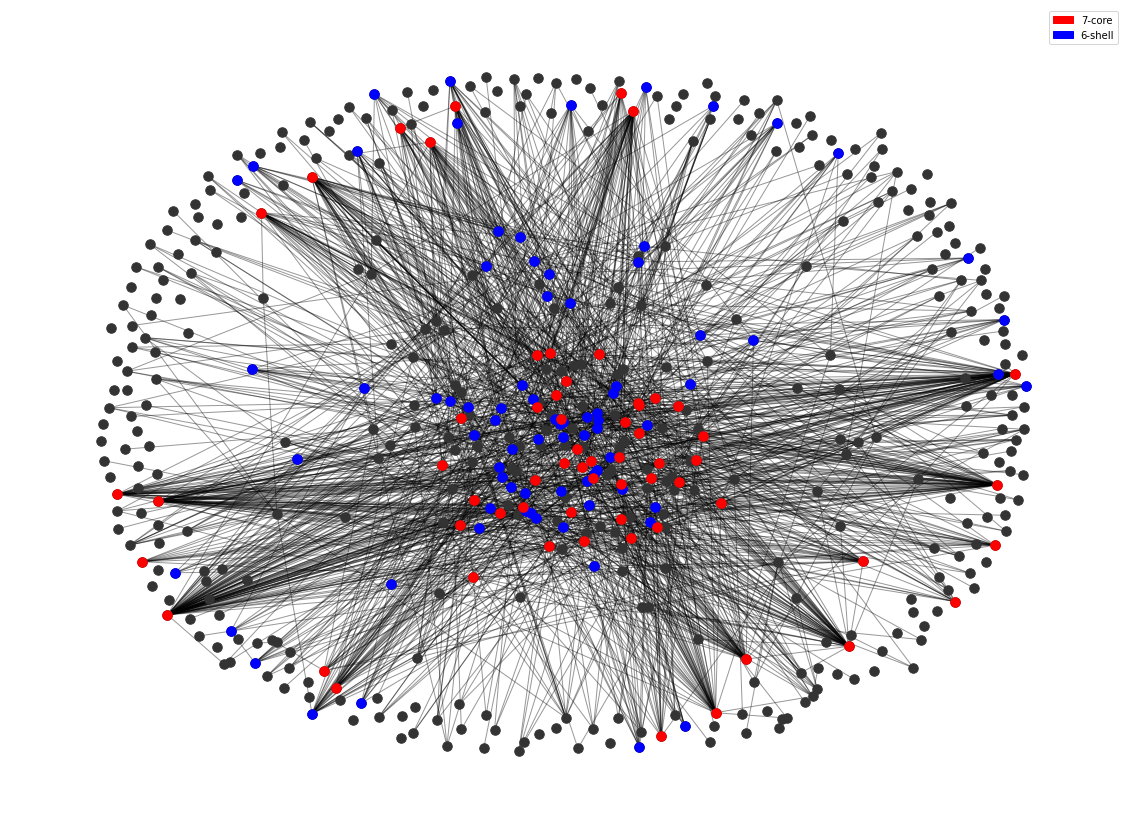

In [ ]:

# Cores mais profundos
shell_6 = nx.k_shell(subgraph_sem_autorreferencia, 6)
core_7 = nx.k_core(subgraph_sem_autorreferencia, 7)

# the degree of network(subgraph_sem_autorreferencia)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph_sem_autorreferencia,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(subgraph_sem_autorreferencia,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph_sem_autorreferencia,
                 pos=pos,
                 node_color="#333333",node_size = 90)

# draw nodes
nodes = nx.draw_networkx_nodes(shell_6,
                 pos=pos,
                 node_color="blue",node_size = 90)

nodes = nx.draw_networkx_nodes(core_7,
                 pos=pos,
                 node_color="red",node_size = 90)

# static legend
red_patch = mpatches.Patch(color='red', label='7-core')
blue_patch = mpatches.Patch(color='blue', label='6-shell')
plt.legend(handles=[red_patch,blue_patch])

plt.axis("off")
plt.savefig('./figuras/k-core_sociopatterns.png', transparent=True,dpi=600)
plt.show()

Os nós destacados em azul na figura (6 shell) compõem a última camada extraída antes de sobrar apenas o core (7 core) em vermelho, unindo ambos temos as duas ultimas camadas da decomposição da nossa rede.

Abaixo os usuários que compõem as últimas camadas da rede.

In [ ]:
print("Usuários no 7 Core da rede:")
print(list(core_7.nodes()))
print("\nUsuários no 6 Shell da rede:")
print(list(shell_6.nodes()))

Usuários no 7 Core da rede:
['ruebekah', 'juuh6520', 'imperiobey', 'thnkulmj', 'Isabeliagomes', 'eumaria', 'CentralReaIity', 'mlkfdsa', 'dorismac64', 'Lel20950324', 'doragouvea', 'tracklist', 'PedroScooby', 'LohCorreaa', 'suelivitoria', 'Naiarazevedo', 'Jucy27384738', 'Dantinhas', 'jadre_oficial', 'TvViciada', 'GregoMalandro', 'annaca207', 'beatrixana11', '_seisanjos', 'karolacranessa', 'japacica', 'Petereilissh', 'TalitaS11216598', 'choquei', 'Nnise_Rrose', 'brearps', 'jmileycyrusk', 'Gina35415084', 'DanielF74922660', 'RealitySocial', 'vaidesmaiar', 'canalestrelasyt', 'oficial_deodato', 'voleimomento', 'fezhowrd', 'Alanredd13', 'iasmimdafine', 'JennyNoggy_', 'tia_meigh2', 'juliafagunds20', 'avicmonteiro', 'DHESSIKA16', 'fwntdz', 'wandasinner', 'chicobarney', 'B1aNc4Bass', 'ZAMENZA', 'vitimbrands', 'iampauloandre', 'BonekinhaS22', 'babi', 'bbb', 'Paty13708819', 'tuittaalarii', 'CASIUNABOOKSTAN', 'whomath', 'paiva']

Usuários no 6 Shell da rede:
['larrynoTopo', 'laisfontes10', 'jaqueli9

### Resultado
Observando os nós das últimas camadas da rede, tanto na figura quando na célula anterior, podemos perceber que os nós do core realmente são os que possuem maior nível de conexão com os demais, seguidos logo adiante do 6 core em azul. A decomposição nos ajuda a identificar mais facilmente os nós mais relevantes e observar a quantidade de arestas relacionadas a eles.

# Conclusão

#### Através de todas as análises feitas (Métricas de ranqueamento dos nós, PDF, CDF e decomposição da rede) podemos concluir que a rede analisada possui uma baixa conectividade entre os nós, o que no nosso contexto significa que há poucas menções nos tweets dos usuários aos outros usuários (Mesmo com um tema tão recorrente e atual como o Big Brother Brasil 2022).<br><br>Utilizando a ferramenta Gephi construímos a rede para que fosse possível uma melhor visualização do grafo completo. Nessa construção, o rótulo (Nome dos usuários) e o tamanho dos nós eram proporcionais ao grau deles. Dessa forma, os nós com maior grau obtiveram mais destaque na imagem do que os com menor grau.<br><br>Além disso, você pode ter acesso ao grafo abaixo de forma iterativa através DESSE LINK ou pelo repositório do projeto no github.